<a href="https://colab.research.google.com/github/sebasmos/satellite.extractor/blob/main/satellite_images_hashing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cloud similarity analysis 

In [2]:
!pip install epiweeks

In [3]:
def readImg(img_path, resize_ratio=None):
  img = io.imread(img_path)

  if resize_ratio:
    img_rescale = rescale(img, resize_ratio, anti_aliasing=True)
  
  path_img = os.path.basename(img_path)

  print(path_img, '(origin shape:', img.shape, '-> rescale:', str(img_rescale.shape) + ')')
  return img_rescale, path_img


# Load data from one of the source
def loadData(csv_folder, img_folder, option=None, resize_ratio=None):
  if option is None:
    # Get data by combining from csv and images
    df = loadStructuredData(csv_folder)
    info_dict = combineData(img_folder, df, resize_ratio)
    
    print(len(info_dict['LastDayWeek']), len(info_dict['Image']), len(info_dict['cases_medellin']))

  else:
    # Load data from previous pickle file
    info_dict = 1#loadDataFromPickle(option)
  return info_dict
  

def loadStructuredData(csv_path):
  df = pd.DataFrame()
  if os.path.isdir(csv_path):
    for filename in os.listdir(csv_path):
      file_path = os.path.join(csv_path, filename)
      df = df.append(pd.read_csv(file_path))
  elif os.path.isfile(csv_path):
    df = pd.read_csv(csv_path)
  else:
    print('Error: Not folder or file')
  return df
  
def getEpiWeek(origin_str):
  """Get epi week from string
  """
  date_ls = origin_str.split('-')
  return Week.fromdate(date(int(date_ls[0]), int(date_ls[1]), int(date_ls[2])))
  
def combineData(img_folder, df, resize_ratio=None):
  info_dict = {'LastDayWeek':[], 'cases_medellin':[], 'Image':[], 'epi_week':[], 'path_name':[]}
  img_list = os.listdir(img_folder)

  for index, row in df.iterrows():
    name = row['LastDayWeek']
    week_df = str(getEpiWeek(name))
    case = row['cases_medellin']
    for img_name in img_list:
      
      # If image name is image_2017-12-24.tiff -> get 2017-12-24
      # Reference Links: https://www.w3schools.com/python/ref_string_join.asp, 
      #                  https://stackoverflow.com/questions/13174468/how-do-you-join-all-items-in-a-list/13175535
      new_img_name = ''.join(i for i in img_name if i.isdigit() or i == '-')      

      week_img = str(getEpiWeek(new_img_name))
      #print(f"{week_df} = {week_img}")
      if week_df == week_img:
        #print("ENTRO")
        img_path = os.path.join(img_folder, img_name)
        img, img_path = readImg(img_path, resize_ratio)

        info_dict['Image'].append(img)
        info_dict['LastDayWeek'].append(name)
        info_dict['cases_medellin'].append(case)
        info_dict['epi_week'].append(week_df)
        info_dict['path_name'].append(img_path)
        break

  return info_dict

def splitTrainTestSet(ratio):
  # Split the data into training (ratio) and testing (1 - ratio)
  train_val_ratio = ratio
  train_num = int(len(info_dict['Image']) * train_val_ratio)

  # Change list to array
  origin_dimension_X = np.array(info_dict['Image'])
  labels = np.array(info_dict['cases_medellin'])

  print(''.center(60,'-'))

  origin_X_train = origin_dimension_X[:train_num,:,:,:]
  y_train = labels[:train_num]
  origin_X_test = origin_dimension_X[train_num:,:,:,:]
  y_test = labels[train_num:]

  # print('Total number of weeks:'.ljust(30), len(origin_dimension_X), 'weeks')
  # print('Training input:'.ljust(30), origin_X_train.shape)
  # print('Training output:'.ljust(30), y_train.shape)
  # print('Testing input:'.ljust(30), origin_X_test.shape)
  # print('Testing output:'.ljust(30), y_test.shape) 

  # return origin_X_train, y_train, origin_X_test, y_test

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import os
import time
import sys
sys.path.insert(0,'..')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import  mean_absolute_error
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import seaborn as sns
from scipy import signal
import pickle

from sklearn.decomposition import PCA

from epiweeks import Week, Year
from datetime import date

from datetime import date

from random import randint, randrange
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

import skimage
import cv2
import os
import pandas as pd
import numpy as np
import pickle
import plotly.express as px
import matplotlib.pyplot as plt

# Download metadata:
url = "https://drive.google.com/u/0/uc?id=1RGrXHgvn60L4pHA40M0R0scszHLno5fD&export=download"

url = "https://drive.google.com/file/d/1RGrXHgvn60L4pHA40M0R0scszHLno5fD/view?usp=sharing"

In [5]:
!gdown --id 1RGrXHgvn60L4pHA40M0R0scszHLno5fD
!unzip "dengue.zip" -d .
!rm -f dengue.zip

Downloading...
From: https://drive.google.com/uc?id=1RGrXHgvn60L4pHA40M0R0scszHLno5fD
To: /content/dengue.zip
100% 28.7k/28.7k [00:00<00:00, 32.1MB/s]
Archive:  dengue.zip
replace ./dengue/merge_cases_temperature_WeeklyPrecipitation_timeseries.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./dengue/merge_cases_temperature_WeeklyPrecipitation_timeseries.csv  


## Mount GCP bucket 

In [6]:
# authenticate
from google.colab import auth
auth.authenticate_user()

# set your gcp project
!gcloud config set project mit-hst-dengue

!gsutil -q -m cp -r gs://colombia_sebasmos/DATASET_5_best_cities .

!ls DATASET_5_best_cities/

Updated property [core/project].
Cali  Cúcuta  Ibagué  Medellín	Villavicencio


## Load dataset 

In [7]:
csv_folder = "/content/dengue/merge_cases_temperature_WeeklyPrecipitation_timeseries.csv"

img_folder = "/content/DATASET_5_best_cities/Medellín"

info_dict = loadData(csv_folder, img_folder, resize_ratio=(0.7, 0.7, 1))#gpeg

image_2015-11-01.tiff (origin shape: (745, 747, 12) -> rescale: (522, 523, 12))
image_2015-11-08.tiff (origin shape: (745, 747, 12) -> rescale: (522, 523, 12))
image_2015-11-15.tiff (origin shape: (745, 747, 12) -> rescale: (522, 523, 12))
image_2015-11-22.tiff (origin shape: (745, 747, 12) -> rescale: (522, 523, 12))
image_2015-11-29.tiff (origin shape: (745, 747, 12) -> rescale: (522, 523, 12))
image_2015-12-06.tiff (origin shape: (745, 747, 12) -> rescale: (522, 523, 12))
image_2015-12-13.tiff (origin shape: (745, 747, 12) -> rescale: (522, 523, 12))
image_2015-12-20.tiff (origin shape: (745, 747, 12) -> rescale: (522, 523, 12))
image_2015-12-27.tiff (origin shape: (745, 747, 12) -> rescale: (522, 523, 12))
image_2016-01-03.tiff (origin shape: (745, 747, 12) -> rescale: (522, 523, 12))
image_2016-01-10.tiff (origin shape: (745, 747, 12) -> rescale: (522, 523, 12))
image_2016-01-17.tiff (origin shape: (745, 747, 12) -> rescale: (522, 523, 12))
image_2016-01-24.tiff (origin shape: (74

In [8]:
  # Change list to array
df_med = np.array(info_dict['Image'])
labels = np.array(info_dict['cases_medellin'])
img_names = np.array(info_dict['path_name'])

print(''.center(60,'-'))
print(f"shape origin_dimension_X: {df_med.shape}")
print(f"labels {labels.shape}")
print(f"labels {paths.shape}")

# Filter channels
df_med_rgb = df_med[:,:,:,1:4]
df_med_rgb = np.array(df_med_rgb)

------------------------------------------------------------
shape origin_dimension_X: (164, 522, 523, 12)
labels (164,)
labels (164,)


In [43]:
N_SIZE = len(img_names)
df_test = df_med_rgb[:N_SIZE]
path_test = img_names[:N_SIZE]
print(df_test.shape)
print(path_test.shape)

(164, 522, 523, 3)
(164,)


# Similarity analysis based on [hash imag](https://github.com/JohannesBuchner/imagehash)

In [29]:
!pip install ImageHash
! pip install imutils
import cv2 
from PIL import Image
import imagehash
from imutils import paths
import argparse
import time
import sys
import cv2
import os

In [30]:
def hash_difference(image, hashSize=8):
	resized = cv2.resize(image, (hashSize + 1, hashSize))
	diff = resized[:, 1:] > resized[:, :-1]
	return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

In [44]:
dict_hash = []
for img in df_test:
  img_float32 = np.float32(img)
  image = cv2.cvtColor(img_float32, cv2.COLOR_BGR2RGB)
  imageHash = hash_difference(image)
  dict_hash.append(imageHash)

data = {"img_hash": dict_hash,
        "img_names": path_test }
df = pd.DataFrame(data = data)

In [47]:
df.head(10)

,img_hash,img_names
0,1082029825054682594177703657417264921327714136...,image_2015-11-01.tiff
1,1082029825054682594177703657417264921327714136...,image_2015-11-08.tiff
2,3591786525397209849705251677280222948750308852...,image_2015-11-15.tiff
3,3591786525397209849705251677280222948750308852...,image_2015-11-22.tiff
4,7723991248757702845991348667220473825396663840...,image_2015-11-29.tiff
5,7723991248757702845991348667220473825396663840...,image_2015-12-06.tiff
6,5503212482461189564776023212534235735174831981...,image_2015-12-13.tiff
7,6189770821554048558513150227407084088689581231...,image_2015-12-20.tiff
8,6880878732760416652950870064280036308209758219...,image_2015-12-27.tiff
9,5492652629644850009002618031581405156732231351...,image_2016-01-03.tiff


In [46]:
df.groupby("img_hash").count()

,img_names
img_hash,
17218272793594940962402240,2
359178652539720984970525167728022294875030885226020800,2
404075982836397522778377294067839459799466262553956288,1
1361885695877594395462421933524130600169081439633833920,1
1361885730131539020550846172613275093737405556149194688,1
...,...
6264844718096454694872129133971334190665497270332879245248,1
6265030532044575790046167897340381790336303605295764737792,1
6266204030169321515920067856297607026591899135220331286072,1


,img_hash,img_names
0,3923953698991339694463946046711026117082168134...,3
1,9798094121843714923273770252341072339986264116...,3
2,17218272793594940962402240,2
3,9216225168736309299904616141037865016657132898...,2
4,6189770482576853967595530273092802082623908087...,2
5,6188219984522862916163975973992932353726351425...,2
6,5492676889109993216450142191827314626410290937...,2
7,5492652629644850009002618031581405156732231351...,2
8,5492485011483033081477295638288722722474838635...,2
9,3591786525397209849705251677280222948750308852...,2


164


Text(0.5, 1.0, 'hashes per img')

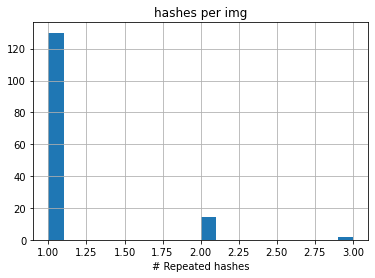

In [49]:
num_img_per_hash = df.groupby("img_hash").size().sort_values(ascending = False).reset_index(name = "img_names")
display(num_img_per_hash.head(10))
print(sum(num_img_per_hash["img_names"]))
num_img_per_hash.hist("img_names", bins = 20)
plt.xlabel('# Repeated hashes')
plt.title('hashes per img')

In [50]:
num_img_per_hash.nunique()

img_hash     146
img_names      3
dtype: int64

* **Remarks**

In order to download the images from sentinel-hub API, a script request is configured using the least amount of clouds per epi week from which the satellite image with least amount of clouds is selected to create a cleaner dataset. 

More in depth, the algorithm selects the best image per week when there is an image with the least interference during the same week; if otherwise - when all images are totally occluded due to cloud interference, an extra day from the following week is added into the epiweek consecutively, until a better image than the ones within this pool is captured - see [code](https://github.com/sebasmos/satellite.extractor/blob/main/linux/request_multiple_images_by_slots.py). 

Despite the mosaicking order is based on the LeastCC algorithm, the fact that there can be cloud-occlouded images during months means that there can be images tha can be repeated a certain number of times within the downloaded dataset (around a month would be reasonable in most places, but this would depend of the local ecosystems and satellite taking the picture). As examplified by the worst case scenario, when every day totally covered by clouds, we expect to encounter cases when a very same image (with the same hash) might be repeated several times, e.g. in the case of some tropical areas like Amazonas, it can be cloudy up to 4 consecutive months from December to April, meaning that an image could be repeated up to 16 times - clearly, in one of the most tropical places on earth. 

The most effective way to analyse the repeatitiveness of this behaviour is using hashes, which maps a data structure of arbitrary size to fixed-sized data. In our case, we use the hashes to create a hash-image dictionary and compare how recurrently the repeat over the entire dataset. On the case above, we counted with the satellite data extracted from [satellite extractor](https://github.com/sebasmos/satellite.extractor), which contains 146 images from the city of Medellin and from which we observed that two images repeated a maximum number of three times, meaning that this city was totally occluded by clouds during a month. *However this is not common, as it can be seen that there are dupplicated images for less than 18 images out of 146 whilst all the other images preserve a unique hash, meaning that each image is unique in resolution and is different from each other in 80 % of the time for the city of Medellin*. A similar analysis can be performed for any dataset, from any city and from any type of dataset.  